In [1]:
#지도학습은 명시적인 정답이 존재
#분류 중 앙상블 방법을 배울 것
#앙상블에는 배깅과 부스팅 방식으로 나뉨
#배깅 : random forest, 배깅 : LIghtGBM, Gradient Boosting, XGBoost 등이 존재

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state = 156)

#붓꽃 데이터 로딩, 학습과 테스트 데이터 세트로 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target, test_size = 0.2, random_state = 11)

#DecisionTree Classifier 학습

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=156)

In [3]:
from sklearn.tree import export_graphviz

#export_graphviz()호출 결과로 out_file로 지정된 tree.dot 파일을 생성함

export_graphviz(dt_clf, out_file = 'tree.dot' , class_names = iris_data.target_names, feature_names = iris_data.feature_names, impurity= True, filled=True)

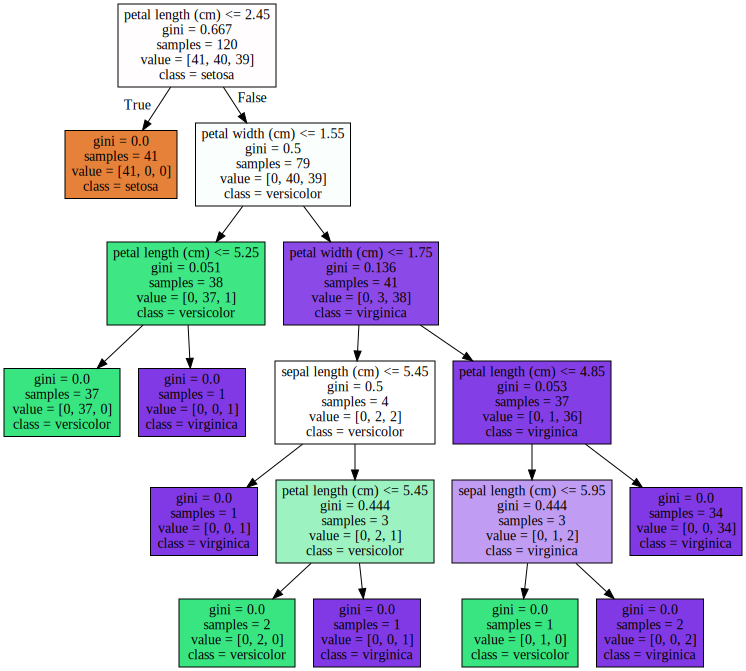

In [4]:
import graphviz

#위에서 생성된 tree.dot파일을 Graphviz가 읽어서 주피터 노트북상에서 시각화

with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

Feature importances:
[0.025 0.    0.555 0.42 ]
sepal length (cm): 0.025
sepal width (cm): 0.000
petal length (cm): 0.555
petal width (cm): 0.420


<AxesSubplot:>

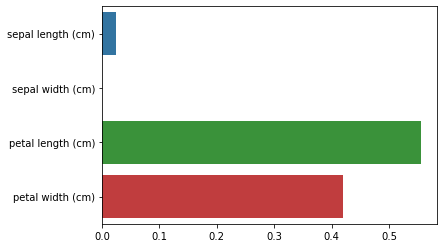

In [5]:
import seaborn as sns
import numpy as np
%matplotlib inline

#feature importance 추출
print('Feature importances:\n{0}'.format(np.round(dt_clf.feature_importances_,3)))

#feature 별 importance 매핑
for name, value in zip(iris_data.feature_names, dt_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name,value))
    
#feature importance를 column 별로 시각화하기
sns.barplot(x=dt_clf.feature_importances_, y=iris_data.feature_names)

#petal width 가 가장 중요함

In [6]:
#결정 트리 과적합(Overfitting)

In [7]:
#사이킷런은 분류를 위한 테스트용 데이터를 쉽게 만들 수 있또록 make_classification()함수를 제공

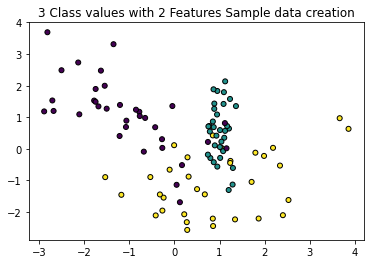

In [8]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('3 Class values with 2 Features Sample data creation')

#2차원 시각화를 위해서 피처 2개, 클래스 3가지 유형의 분류 샘플 데이터 생성

X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state =0)

#그래프 형태로 2개의 피처로 2차원 좌표 시각화, 각 클래스 값으 ㄴ다른 색깔로 표시
plt.scatter(X_features[:,0], X_features[:,1], marker='o', c=y_labels, s =25, edgecolor='k')

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#feature.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('C:/Users/사용자/Desktop/human_activity/features.txt', sep = '\s+',header=None, names=['column_index', 'column_name'])

#feature 명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [10]:
#중복된 피처명이 얼마나 있는지 확인

feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [11]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df= pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis =1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'], axis =1)
    return new_feature_name_df

In [12]:
import pandas as pd

def get_human_dataset():
    #각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('C:/Users/사용자/Desktop/human_activity/features.txt', sep='\s+', header=None, names = ['column_index', 'column_name'])
    
    #중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    #학습 피처 데이터 세트와 테스트 페처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('C:/Users/사용자/Desktop/human_activity/train/X_train.txt', sep='\s+', names = feature_name)
    X_test = pd.read_csv('C:/Users/사용자/Desktop/human_activity/test/X_test.txt', sep='\s+', names = feature_name)
    
    #학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('C:/Users/사용자/Desktop/human_activity/train/y_train.txt', sep='\s+', header =None, names =['action'])
    y_test = pd.read_csv('C:/Users/사용자/Desktop/human_activity/test/y_test.txt', sep='\s+', header =None, names =['action'])

    #로드된 학습/테스트용 DataFrame을 보두 반환
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [13]:
print("## 학습 피처 데이터셋 info()")
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [14]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state = 156)
dt_clf.fit(X_train, y_train)

pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도 : {0:.4f}'.format(accuracy))

#DecisionTreeClassifier 의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터 : \n', dt_clf.get_params())

결정 트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터 : 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [16]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring ='accuracy', cv = 5, verbose =1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8513
GridSearchCV 최적 하이퍼 파라미터: 0.8513444970102249


In [17]:
#GridSearchCV 객체의 cv_results_속성을 DataFrame으로 생성
#cv세트에 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치를 가지고 있다.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

#max_depth  파라미터 값과 그떄의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [18]:
max_depths = [6,8,10,12,16,20,24]

#max_depth값을 변화하면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth = depth, random_state =156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도 : {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도 : 0.8558
max_depth = 8 정확도 : 0.8707
max_depth = 10 정확도 : 0.8673
max_depth = 12 정확도 : 0.8646
max_depth = 16 정확도 : 0.8575
max_depth = 20 정확도 : 0.8548
max_depth = 24 정확도 : 0.8548


In [19]:
params = {
    'max_depth' : [6,8],
    'min_samples_split' : [16,24],
    
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring ='accuracy', cv = 5, verbose =1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 : {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
GridSearchCV 최고 평균 정확도 수치 : 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [20]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print("결정 트리 예측 정확도 :{0:.4f}".format(accuracy))

결정 트리 예측 정확도 :0.8717


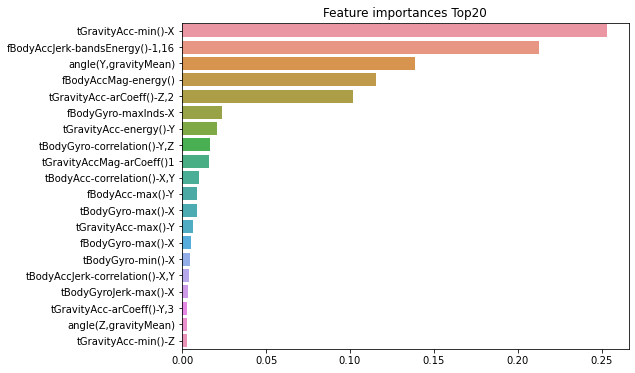

In [21]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

#Top 중요도로 정렬을 쉽게 하고, 시본(seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)

#중요도 값 순으로 Series 정렬
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [22]:
#앙상블 학습
#앙상블을 통한 분류는 여러개의 분류기를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도축하는 기법

In [23]:
#보팅 분류기를 통한 위스콘신 유방암 데이터 세트 이진 분류 예측

import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
#개별 모델은 로지스틱 회귀와 KNN임
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 / estimators & voting
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ('KNN',knn_clf)], voting= 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state =156)


#VotingClassifier 학습/예측/평가

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0: .4f}'.format(accuracy_score(y_test, pred)))

Voting 분류기 정확도 :  0.9474


In [25]:
#개별 모델의 학습/예측 평가

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test,pred)))

LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


In [26]:
#랜덤 포레스트

In [27]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy))

랜덤 포레스트 정확도:0.9253


In [28]:
#랜덤 포레스트 하이퍼 파라미터 튜닝하기

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' :[6,8,10,12],
    'min_samples_leaf':[8,12,18],
    'min_samples_split':[8,16,20]
}

#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state =0, n_jobs =-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [29]:
print('최적 하이퍼 파라미터 : \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [30]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth = 10, min_samples_leaf = 8 , min_samples_split=8, random_state=0)

rf_clf1.fit(X_train, y_train)
pred= rf_clf1.predict(X_test)
print('예측정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

예측정확도: 0.9165


In [31]:
print(X_train.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=561)


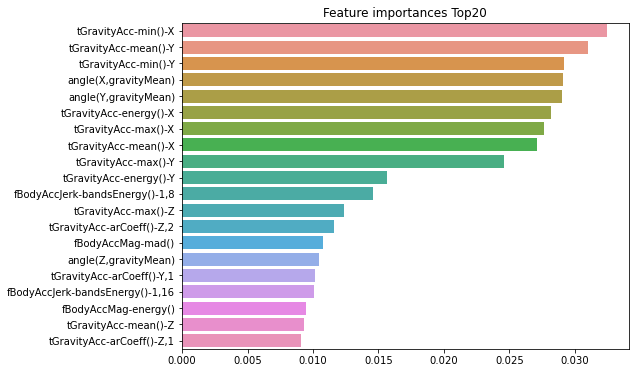

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8,6))
plt.title('Feature importances Top20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [33]:
#GBM(Gradient Boosting Machine)

In [34]:
#부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

In [38]:
X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
#gbm 수행 시간 측정, 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state =0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print("GBM 정확도 : {0: .4f}".format(gb_accuracy))
print('GBM 수행시간 : {0: .1f}초'.format(time.time() -start_time))

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100,500],
    'learning_state':[0.05,0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid = params, cv =2, verbose =1)
grid_cv.fit(X_train,y_train)
print('최적의 파라미터 : ',grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))